In [3]:
from datetime import datetime
from azure.ai.ml.entities import Data

from azure.ai.ml import automl, Input
from azure.ai.ml.constants import AssetTypes
from azure.ai.ml import MLClient
from azure.ai.ml.entities import ComputeInstance, AmlCompute
from azure.identity import DefaultAzureCredential
import os
#my_training_data_input = Input(type=AssetTypes.MLTABLE, path="azureml://datastores/workspaceblobstore/paths/vision-classification/train")
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

credential = DefaultAzureCredential()
ml_client = None
try:
    ml_client = MLClient.from_config(credential)
except Exception as ex:
    print(ex)
    # Enter details of your AML workspace
    subscription_id = "fcd507c3-2157-4d7e-8f34-7f992556b828"
    resource_group = "tumor_detection_project"
    workspace = "tumor_detection"
    ml_client = MLClient(credential, subscription_id, resource_group, workspace)

os.makedirs("data", exist_ok=True)

#my_data = Data(
#    path="./data/brainMRI",
#    type=AssetTypes.URI_FOLDER,
#    description="Brain MRI images for binary clasiffication",
#    name="brain-mri-images",
#)

#uri_folder_data_asset = ml_client.data.create_or_update(my_data)

#print(uri_folder_data_asset)
#print("")
#print("Path to folder in Blob Storage:")
#print(uri_folder_data_asset.path)

Found the config file in: /config.json


In [5]:
import json
import os

src_images = "./data/brainMRI"

# We'll copy each JSONL file within its related MLTable folder
training_mltable_path = "./data/training-mltable-folder/"
validation_mltable_path = "./data/validation-mltable-folder/"

train_validation_ratio = 5

# Path to the training and validation files
train_annotations_file = os.path.join(training_mltable_path, "train_annotations.jsonl")
validation_annotations_file = os.path.join(
    validation_mltable_path, "validation_annotations.jsonl"
)

# Baseline of json line dictionary
json_line_sample = {
    "image_url": uri_folder_data_asset.path,
    "label": "",
}

index = 0
# Scan each sub directary and generate a jsonl line per image, distributed on train and valid JSONL files
with open(train_annotations_file, "w") as train_f:
    with open(validation_annotations_file, "w") as validation_f:
        for className in os.listdir(src_images):
            subDir = src_images + '/' + className
            print(subDir)
            if not os.path.isdir(subDir):
                continue
            # Scan each sub directary
            print("Parsing " + subDir)
            for image in os.listdir(subDir):
                json_line = dict(json_line_sample)
                json_line["image_url"] += f"{className}/{image}"
                json_line["label"] = className
                if index % train_validation_ratio == 0:
                    # validation annotation
                    validation_f.write(json.dumps(json_line) + "\n")
                else:
                    # train annotation
                    train_f.write(json.dumps(json_line) + "\n")
                index += 1                

NameError: name 'uri_folder_data_asset' is not defined

In [26]:
from azure.ai.ml.automl import SearchSpace, ClassificationPrimaryMetrics
from azure.ai.ml.sweep import (
    Choice,
    Choice,
    Uniform,
    BanditPolicy,
)
# Training MLTable defined locally, with local data to be uploaded
my_training_data_input = Input(type=AssetTypes.MLTABLE, path="./data/training-mltable-folder/")

# Validation MLTable defined locally, with local data to be uploaded
my_validation_data_input = Input(type=AssetTypes.MLTABLE, path= "./data/validation-mltable-folder/")



In [35]:
compute_name = "tumorCompute"
exp_name = "brain-tumor-image-classification-experiment"

image_classification_job = automl.image_classification(
    compute=compute_name,
    experiment_name=exp_name,
    training_data=my_training_data_input,
    validation_data=my_validation_data_input,
    target_column_name="label",
    primary_metric=ClassificationPrimaryMetrics.ACCURACY

)


In [36]:

image_classification_job.set_limits(
    timeout_minutes=60,
    max_trials=10,
    max_concurrent_trials=1,
)

image_classification_job.extend_search_space(
    [
        SearchSpace(
            model_name=Choice(["vitb16r224", "vits16r224"]),
            learning_rate=Uniform(0.001, 0.01),
            number_of_epochs=Choice([15, 30]),
        ),
        SearchSpace(
            model_name=Choice(["seresnext", "resnet50"]),
            learning_rate=Uniform(0.001, 0.01),
            layers_to_freeze=Choice([0, 2]),
        ),
    ]
)

image_classification_job.set_sweep(
    sampling_algorithm="Random",
    early_termination=BanditPolicy(
        evaluation_interval=2, slack_factor=0.2, delay_evaluation=6
    ),
)

In [37]:
# Submit the AutoML job
returned_job = ml_client.jobs.create_or_update(image_classification_job)

print(f"Created job: {returned_job}")
ml_client.jobs.stream(returned_job.name)

Created job: ImageClassificationJob({'log_verbosity': <LogVerbosity.INFO: 'Info'>, 'target_column_name': 'label', 'validation_data_size': None, 'task_type': <TaskType.IMAGE_CLASSIFICATION: 'ImageClassification'>, 'training_data': {'type': 'mltable', 'path': 'azureml://datastores/workspaceblobstore/paths/LocalUpload/700b895a4121087ed9e870f75722e14c/training-mltable-folder'}, 'validation_data': {'type': 'mltable', 'path': 'azureml://datastores/workspaceblobstore/paths/LocalUpload/4b1a6e2ea4de23bef447a5ff8d477d5b/validation-mltable-folder'}, 'test_data': None, 'environment_id': None, 'environment_variables': None, 'outputs': {}, 'type': 'automl', 'status': 'NotStarted', 'log_files': None, 'name': 'amiable_roti_d7c3tqkmr3', 'description': None, 'tags': {}, 'properties': {}, 'id': '/subscriptions/fcd507c3-2157-4d7e-8f34-7f992556b828/resourceGroups/tumor_detection_project/providers/Microsoft.MachineLearningServices/workspaces/tumor_detection/jobs/amiable_roti_d7c3tqkmr3', 'Resource__source_p

In [47]:
import mlflow
from mlflow.tracking.client import MlflowClient

MLFLOW_TRACKING_URI = ml_client.workspaces.get(
    name=ml_client.workspace_name
).mlflow_tracking_uri

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

mlflow_client = MlflowClient()
job_name = 'amiable_roti_d7c3tqkmr3'

# Example if providing an specific Job name/ID
# job_name = "salmon_camel_5sdf05xvb3"

# Get the parent run
mlflow_parent_run = mlflow_client.get_run(job_name)

best_child_run_id = mlflow_parent_run.data.tags["automl_best_child_run_id"]
print("Found best child run id: ", best_child_run_id)

best_run = mlflow_client.get_run(best_child_run_id)

print("Best child run: ")
print(best_run)


Found best child run id:  amiable_roti_d7c3tqkmr3_HD_6
Best child run: 
<Run: data=<RunData: metrics={'AUC_binary': 0.96265,
 'AUC_macro': 0.96265,
 'AUC_micro': 0.97,
 'AUC_weighted': 0.96265,
 'accuracy': 0.98,
 'accuracy_train': 0.87685,
 'average_precision_score_binary': 0.96356,
 'average_precision_score_macro': 0.96766,
 'average_precision_score_micro': 0.96498,
 'average_precision_score_weighted': 0.96668,
 'f1_score_binary': 0.98413,
 'f1_score_macro': 0.97855,
 'f1_score_micro': 0.98,
 'f1_score_weighted': 0.97989,
 'log_loss': 0.22704,
 'log_loss_train': 0.29414,
 'precision_score_binary': 0.96875,
 'precision_score_macro': 0.98438,
 'precision_score_micro': 0.98,
 'precision_score_weighted': 0.98062,
 'recall_score_binary': 1.0,
 'recall_score_macro': 0.97368,
 'recall_score_micro': 0.98,
 'recall_score_weighted': 0.98}, params={}, tags={'hyperparameters': '{"model": {"learning_rate": 0.0040236584140342195, '
                    '"model_name": "vits16r224", "number_of_epochs

In [22]:
from azure.ai.ml.entities import (
    ManagedOnlineEndpoint,
    ManagedOnlineDeployment,
    Model,
    Environment,
    CodeConfiguration,
    ProbeSettings,
)

model_name = "best-brain-tumor-class"
model = Model(
    path=f"azureml://jobs/{best_run.info.run_id}/outputs/artifacts/outputs/mlflow-model/",
    name=model_name,
    description="my sample image classification multiclass model",
    type=AssetTypes.MLFLOW_MODEL,
)

# for downloaded file
# model = Model(
#     path="artifact_downloads/outputs/mlflow-model/",
#     name=model_name,
#     description="my sample image classification multiclass model",
#     type=AssetTypes.MLFLOW_MODEL,
# )

registered_model = ml_client.models.create_or_update(model)

NameError: name 'best_run' is not defined

In [31]:
import datetime
from azure.ai.ml.entities import (
    ManagedOnlineEndpoint,
    ManagedOnlineDeployment,
    Model,
    Environment,
    CodeConfiguration,
    ProbeSettings,
)

online_endpoint_name = "tumor-endpoint-test" + datetime.datetime.now().strftime(
    "%m%d%H%M"
)

# create an online endpoint
endpoint = ManagedOnlineEndpoint(
    name=online_endpoint_name,
    description="Test endpoint for web app",
    auth_mode="key",
    tags={"foo": "bar"},
)

In [32]:
ml_client.begin_create_or_update(endpoint).result()


ManagedOnlineEndpoint({'public_network_access': 'Enabled', 'provisioning_state': 'Succeeded', 'scoring_uri': 'https://tumor-endpoint-test11261846.westeurope.inference.ml.azure.com/score', 'openapi_uri': 'https://tumor-endpoint-test11261846.westeurope.inference.ml.azure.com/swagger.json', 'name': 'tumor-endpoint-test11261846', 'description': 'Test endpoint for web app', 'tags': {'foo': 'bar'}, 'properties': {'azureml.onlineendpointid': '/subscriptions/fcd507c3-2157-4d7e-8f34-7f992556b828/resourcegroups/tumor_detection_project/providers/microsoft.machinelearningservices/workspaces/tumor_detection/onlineendpoints/tumor-endpoint-test11261846', 'AzureAsyncOperationUri': 'https://management.azure.com/subscriptions/fcd507c3-2157-4d7e-8f34-7f992556b828/providers/Microsoft.MachineLearningServices/locations/westeurope/mfeOperationsStatus/oe:53b446ab-b72f-4d0b-a1ab-785ec801a871:7a34559b-3bfc-43d1-8b89-a3c922a67cf3?api-version=2022-02-01-preview'}, 'id': '/subscriptions/fcd507c3-2157-4d7e-8f34-7f9

In [33]:
registered_model = ml_client.models.get(name="best-brain-tumor-classification", version="1")

deployment = ManagedOnlineDeployment(
    name="ic-mc-fridge-items-mlflow-deploy",
    endpoint_name=online_endpoint_name,
    model=registered_model.id,
    instance_type="Standard_E2s_v3",
    instance_count=1,
    liveness_probe=ProbeSettings(
        failure_threshold=30,
        success_threshold=1,
        timeout=2,
        period=10,
        initial_delay=2000,
    ),
    readiness_probe=ProbeSettings(
        failure_threshold=10,
        success_threshold=1,
        timeout=10,
        period=10,
        initial_delay=2000,
    ),
)

In [34]:

ml_client.online_deployments.begin_create_or_update(deployment).result()


Check: endpoint tumor-endpoint-test11261846 exists
data_collector is not a known attribute of class <class 'azure.ai.ml._restclient.v2022_02_01_preview.models._models_py3.ManagedOnlineDeployment'> and will be ignored


ManagedOnlineDeployment({'private_network_connection': False, 'data_collector': None, 'provisioning_state': 'Succeeded', 'endpoint_name': 'tumor-endpoint-test11261846', 'type': 'Managed', 'name': 'ic-mc-fridge-items-mlflow-deploy', 'description': None, 'tags': {}, 'properties': {'AzureAsyncOperationUri': 'https://management.azure.com/subscriptions/fcd507c3-2157-4d7e-8f34-7f992556b828/providers/Microsoft.MachineLearningServices/locations/westeurope/mfeOperationsStatus/od:53b446ab-b72f-4d0b-a1ab-785ec801a871:5e88c624-7fb1-460f-901f-f9e0ac77529c?api-version=2022-02-01-preview'}, 'id': '/subscriptions/fcd507c3-2157-4d7e-8f34-7f992556b828/resourceGroups/tumor_detection_project/providers/Microsoft.MachineLearningServices/workspaces/tumor_detection/onlineEndpoints/tumor-endpoint-test11261846/deployments/ic-mc-fridge-items-mlflow-deploy', 'Resource__source_path': None, 'base_path': '/mnt/batch/tasks/shared/LS_root/mounts/clusters/notebook-tumor-compute/code/Users/01159314', 'creation_context':

In [35]:
endpoint.traffic = {"ic-mc-fridge-items-mlflow-deploy": 100}
ml_client.begin_create_or_update(endpoint).result()

ManagedOnlineEndpoint({'public_network_access': 'Enabled', 'provisioning_state': 'Succeeded', 'scoring_uri': 'https://tumor-endpoint-test11261846.westeurope.inference.ml.azure.com/score', 'openapi_uri': 'https://tumor-endpoint-test11261846.westeurope.inference.ml.azure.com/swagger.json', 'name': 'tumor-endpoint-test11261846', 'description': 'Test endpoint for web app', 'tags': {'foo': 'bar'}, 'properties': {'azureml.onlineendpointid': '/subscriptions/fcd507c3-2157-4d7e-8f34-7f992556b828/resourcegroups/tumor_detection_project/providers/microsoft.machinelearningservices/workspaces/tumor_detection/onlineendpoints/tumor-endpoint-test11261846', 'AzureAsyncOperationUri': 'https://management.azure.com/subscriptions/fcd507c3-2157-4d7e-8f34-7f992556b828/providers/Microsoft.MachineLearningServices/locations/westeurope/mfeOperationsStatus/oe:53b446ab-b72f-4d0b-a1ab-785ec801a871:9f905bd4-d192-4726-95b0-36adb3fc9041?api-version=2022-02-01-preview'}, 'id': '/subscriptions/fcd507c3-2157-4d7e-8f34-7f9

In [36]:
endpoint = ml_client.online_endpoints.get(name=online_endpoint_name)

# existing traffic details
print(endpoint.traffic)

# Get the scoring URI
print(endpoint.scoring_uri)

{'ic-mc-fridge-items-mlflow-deploy': 100}
https://tumor-endpoint-test11261846.westeurope.inference.ml.azure.com/score


In [38]:
import base64

sample_image = "./data/brainMRI/yes/Y1.jpg"


def read_image(image_path):
    with open(image_path, "rb") as f:
        return f.read()


request_json = {
    "input_data": {
        "columns": ["image"],
        "data": [base64.encodebytes(read_image(sample_image)).decode("utf-8")],
    }
}

In [39]:
import json

request_file_name = "sample_request_data.json"

with open(request_file_name, "w") as request_file:
    json.dump(request_json, request_file)

In [40]:
resp = ml_client.online_endpoints.invoke(
    endpoint_name=online_endpoint_name,
    deployment_name=deployment.name,
    request_file=request_file_name,
)

yes (0.989)


<Figure size 1296x864 with 0 Axes>

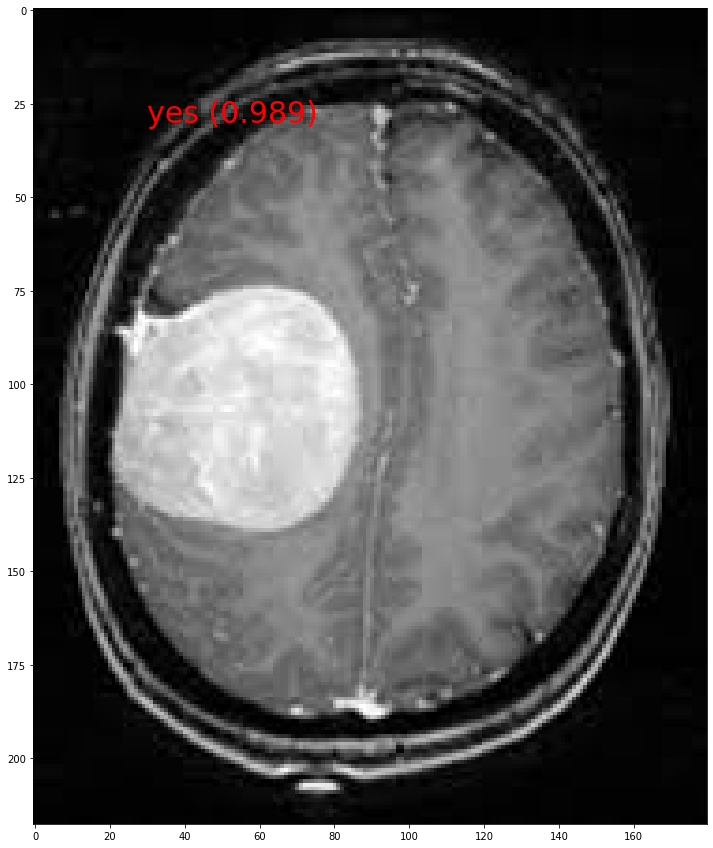

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import numpy as np
import json

IMAGE_SIZE = (18, 12)
plt.figure(figsize=IMAGE_SIZE)
img_np = mpimg.imread(sample_image)
img = Image.fromarray(img_np.astype("uint8"), "RGB")
x, y = img.size

fig, ax = plt.subplots(1, figsize=(15, 15))
# Display the image
ax.imshow(img_np)

prediction = json.loads(resp)[0]
label_index = np.argmax(prediction["probs"])
label = prediction["labels"][label_index]
conf_score = prediction["probs"][label_index]

display_text = "{} ({})".format(label, round(conf_score, 3))
print(display_text)

color = "red"
plt.text(30, 30, display_text, color=color, fontsize=30)

plt.show()

In [42]:
ml_client.online_endpoints.begin_delete(name=online_endpoint_name)


...........................................